# Santander Customer Transaction Prediction
This notebook provides an **end‑to‑end, reproducible baseline** for the Kaggle competition. Run the cells in order on **Google Colab**.

*Competition page*: https://www.kaggle.com/competitions/santander-customer-transaction-prediction


## 1  Environment & data set‑up
Colab tips:
1. Upload your `kaggle.json` (API key) to `/content` and run the first cell.
2. **OR** manually upload the four CSVs from [the Data tab](https://www.kaggle.com/competitions/santander-customer-transaction-prediction/data) into Colab.
3. GPU is *not* required but speeds up LightGBM.


In [ ]:
!pip -q install kaggle lightgbm optuna --upgrade

import os, zipfile, warnings, math, gc, random, json
import numpy as np, pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')
SEED = 42
np.random.seed(SEED)

# ── 1. Download from Kaggle if credentials present ──────────────────────────── #
if os.path.exists('/content/kaggle.json'):
    os.environ['KAGGLE_CONFIG_DIR'] = '/content'
    !kaggle competitions download -c santander-customer-transaction-prediction -p /content --quiet

# ── 2. Unzip *all* .zip files in /content (idempotent) ─────────────────────── #
for fname in os.listdir('/content'):
    if fname.endswith('.zip'):
        zpath = os.path.join('/content', fname)
        with zipfile.ZipFile(zpath) as z:
            z.extractall('/content')   # extracts only if not already present

print('Setup complete ✅')


Setup complete ✅


## 2  Load data

In [ ]:
PATH = '/content'
train = pd.read_csv(f'{PATH}/train.csv')
test  = pd.read_csv(f'{PATH}/test.csv')
print(train.shape, test.shape)
display(train.head())

(200000, 202) (200000, 201)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


## 3  Quick EDA

Target distribution:
target
0    0.89951
1    0.10049
Name: proportion, dtype: float64


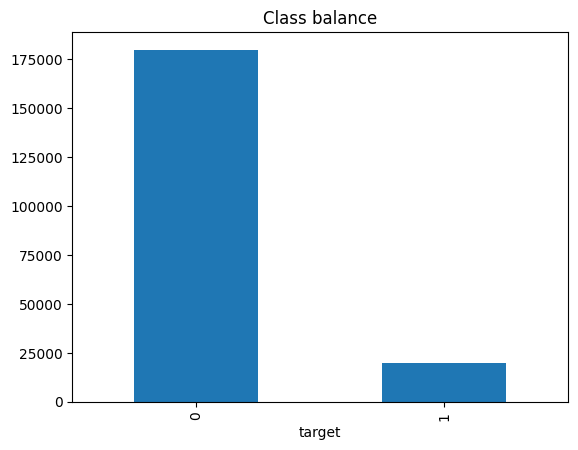

In [ ]:
print('Target distribution:')
print(train['target'].value_counts(normalize=True))
train['target'].value_counts().plot(kind='bar', title='Class balance'); plt.show()

## Class-imbalance quick facts

In [ ]:
from collections import Counter
neg, pos = Counter(train['target']).values()
print(f"Minority-class ratio: {pos / (neg+pos):.2%}")
print(f"Baseline accuracy if you predict 0: {neg / (neg+pos):.2%}")
print(f"Balanced log-loss lower bound (no skill): {-np.mean([np.log1p(-pos/(neg+pos)), np.log(pos/(neg+pos))]):.4f}")


Minority-class ratio: 10.05%
Baseline accuracy if you predict 0: 89.95%
Balanced log-loss lower bound (no skill): 1.2018


## Missing-value & constant-feature scan

In [ ]:
nulls = train.isnull().sum().sort_values(ascending=False)
display(nulls.head())
const_cols = [c for c in train.columns if train[c].nunique() == 1]
print(f"Constant columns: {const_cols[:5]} … total {len(const_cols)}")

,0
ID_code,0
target,0
var_0,0
var_1,0
var_2,0


Constant columns: [] … total 0


## Distribution diagnostics per class

3.1 Univariate KS statistic

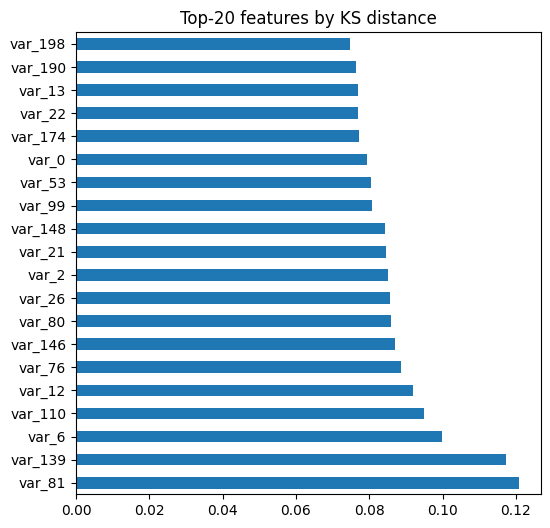

In [ ]:
from scipy.stats import ks_2samp
ks_scores = {c: ks_2samp(train.loc[train.target==0, c],
                         train.loc[train.target==1, c]).statistic
             for c in train.columns if c.startswith('var_')}
(pd.Series(ks_scores)
   .sort_values(ascending=False)[:20]
   .plot.barh(figsize=(6,6), title='Top-20 features by KS distance'));


## 4  Cross‑validation & model
We use **LightGBM (Gradient Boosted Decision Trees)** – a strong baseline for tabular numeric data – with **5‑fold Stratified CV** to respect class imbalance and obtain an out‑of‑fold (OOF) AUC estimate.

In [ ]:
FEATURES = [c for c in train.columns if c.startswith('var_')]
TARGET   = 'target'

params = dict(objective='binary',
              metric='auc',
              boosting_type='gbdt',
              learning_rate=0.02,
              num_leaves=64,
              feature_fraction=0.20,
              bagging_fraction=0.90,
              bagging_freq=1,
              seed=SEED,
              n_jobs=-1)

NFOLDS = 5
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))

for fold, (train_idx, valid_idx) in enumerate(skf.split(train[FEATURES], train[TARGET]), 1):
    X_train, y_train = train.loc[train_idx, FEATURES], train.loc[train_idx, TARGET]
    X_valid, y_valid = train.loc[valid_idx, FEATURES], train.loc[valid_idx, TARGET]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model = lgb.train(params, lgb_train,
                      num_boost_round=2000,
                      valid_sets=[lgb_train, lgb_valid],
                      valid_names=['train','valid'],
                      early_stopping_rounds=200,
                      verbose_eval=200)

    oof_preds[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
    test_preds += model.predict(test[FEATURES], num_iteration=model.best_iteration) / NFOLDS

    print(f'Fold {fold} AUC: {roc_auc_score(y_valid, oof_preds[valid_idx]):.5f}')

print('CV AUC:', roc_auc_score(train[TARGET], oof_preds))

### Feature importance (top 30)

In [ ]:
importances = model.feature_importance()
feat_imp = pd.DataFrame({'feature': FEATURES, 'importance': importances})
feat_imp.nlargest(30,'importance').plot(kind='barh', x='feature', figsize=(6,8), title='LightGBM feature importance'); plt.gca().invert_yaxis(); plt.show()

## 5  Create submission

In [ ]:
submission = pd.read_csv(f'{PATH}/sample_submission.csv')
submission['target'] = test_preds
submission.to_csv('submission.csv', index=False)
print('Saved: submission.csv')

## 6  Next steps
* **Hyperparameter tuning** – e.g. Optuna, Bayesian optimisation
* **Ensembling** multiple seeds / models (e.g. CatBoost, NN, TabNet)
* **Feature engineering** – interaction features, PCA projections
* **CV scheme sensitivity** – check leaks, time‑based splits if applicable
